<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [4]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [5]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.2))

# model.add(layers.Dense(216, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# # model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [6]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [7]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=120,
                    batch_size=128,
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/120
391/391 [==============================] - 8s 17ms/step - loss: 0.6713 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.4761 - val_sparse_categorical_accuracy: 0.8314
Epoch 2/120
391/391 [==============================] - 5s 13ms/step - loss: 0.4937 - sparse_categorical_accuracy: 0.8277 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8477
Epoch 3/120
391/391 [==============================] - 6s 15ms/step - loss: 0.4523 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.4074 - val_sparse_categorical_accuracy: 0.8587
Epoch 4/120
391/391 [==============================] - 6s 14ms/step - loss: 0.4263 - sparse_categorical_accuracy: 0.8487 - val_loss: 0.3764 - val_sparse_categorical_accuracy: 0.8706
Epoch 5/120
391/391 [==============================] - 5s 13ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.8542 - val_loss: 0.3660 - val_sparse_categorical_accuracy: 0.8712
Epoch 6/120
391/391 [==============================] - 6s 16ms/step - loss: 0.3897 - spars

In [8]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


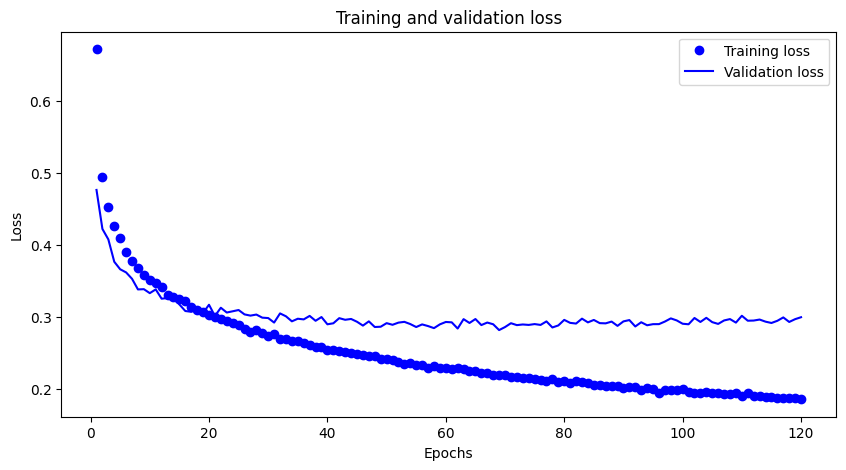

<Figure size 640x480 with 0 Axes>

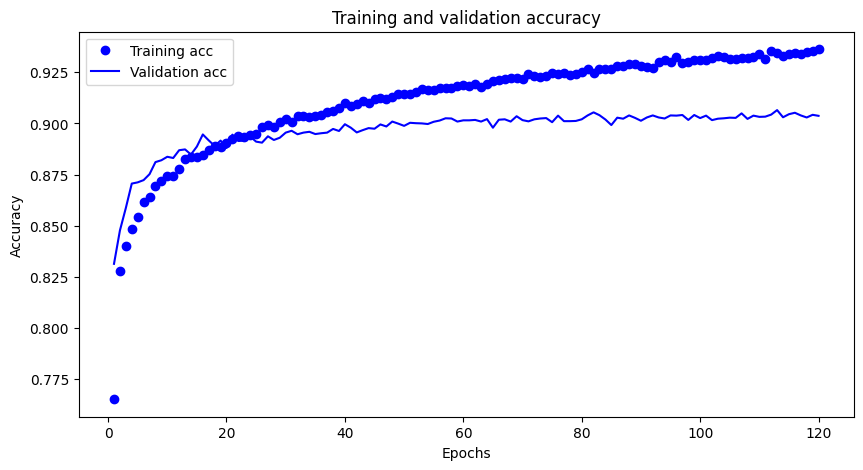

In [9]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [10]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [11]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [12]:
predictions[0]

array([0.08533872, 0.08533872, 0.08533871, 0.08533871, 0.08533871,
       0.08533945, 0.08533871, 0.08535142, 0.08533871, 0.23193812],
      dtype=float32)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2